<a href="https://colab.research.google.com/github/mediocreatmybest/gaslightingeveryone/blob/main/examples/autopipeline_lcm_lora_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --extra-index-url https://download.pytorch.org/whl/cu118 \
torch \
bitsandbytes \
Pillow \
SciPy  \
safetensors \
git+https://github.com/huggingface/transformers \
git+https://github.com/huggingface/accelerate \
git+https://github.com/huggingface/diffusers



In [ ]:
# Note / need to be more memory efficent on GPU / etc.
import torch
from diffusers import AutoPipelineForText2Image, AutoPipelineForImage2Image
from diffusers import (
    DDPMScheduler,
    DDIMScheduler,
    PNDMScheduler,
    LMSDiscreteScheduler,
    LCMScheduler,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    DPMSolverMultistepScheduler,
    DPMSolverSinglestepScheduler,
    UniPCMultistepScheduler,
    DEISMultistepScheduler,
    HeunDiscreteScheduler,
    KDPM2DiscreteScheduler,
    KDPM2AncestralDiscreteScheduler,
)

# Set pipeline to None for Pipeline so we can detect if its loaded later
pipeline = None

# Set SD model to use else set None.
repo_id = "digiplay/Photon_v1"
adapter_id = "latent-consistency/lcm-lora-sdv1-5"

# Lets set available schedulers
# https://huggingface.co/docs/diffusers/using-diffusers/schedulers
ddpm = DDPMScheduler.from_pretrained(repo_id, subfolder="scheduler")
ddim = DDIMScheduler.from_pretrained(repo_id, subfolder="scheduler")
pndm = PNDMScheduler.from_pretrained(repo_id, subfolder="scheduler")
lms = LMSDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler")
lcm = LCMScheduler.from_pretrained(repo_id, subfolder="scheduler")
euler_anc = EulerAncestralDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler")
euler = EulerDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler")
dpm = DPMSolverMultistepScheduler.from_pretrained(repo_id, subfolder="scheduler")
dpmss = DPMSolverSinglestepScheduler.from_pretrained(repo_id, subfolder="scheduler")
uni = UniPCMultistepScheduler.from_pretrained(repo_id, subfolder="scheduler")
deis = DEISMultistepScheduler.from_pretrained(repo_id, subfolder="scheduler")
heun = HeunDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler") #Slow on CPU
kdpm2 = KDPM2DiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler") #Slow on CPU
kdpm2a = KDPM2AncestralDiscreteScheduler.from_pretrained(repo_id, subfolder="scheduler") #Slow on CPU

# Now lets set the scheduler
scheduler = lcm

# Set device to Cuda if available
if torch.cuda.is_available():
    device = "cuda"
# CPU fallback
else:
    device = "cpu"

# Create pipline loading
def load_pipeline(repo_id, scheduler):
    # global device
    global device
    # Create pipeline
    pipeline = AutoPipelineForText2Image.from_pretrained(repo_id,
                                                         scheduler=scheduler,
                                                         safety_checker=None,
                                                         use_safetensors=True).to(device)
    return pipeline

# Load pipeline with lora
if pipeline is not None:
    pipeline.load_lora_wights(adapter_id)
else:
# Else load pipeline and then lora
  pipeline = load_pipeline(repo_id=repo_id, scheduler=scheduler)
  pipeline.load_lora_weights(adapter_id)

# Start prompt and pipeline tasks
prompt = "Astronaut in a jungle, broad brush strokes on a painting, hyperdetailed digital painting, 8k, digital painting and concept art with loose brush strokes"
negative_prompt="Pink Elephants on Parade"
guidance_scale=0
height=640
width=512
num_images_per_prompt=1
num_inference_steps=6
image = pipeline(prompt=prompt,
                 negative_prompt=negative_prompt,
                 cross_attention_kwargs={"scale": 1.0},
                 guidance_scale=guidance_scale,
                 height=height, width=width,
                 num_images_per_prompt=num_images_per_prompt,
                 num_inference_steps=num_inference_steps).images[0]

In [ ]:
display(image)

In [ ]:
# Create Copy with PIL
from PIL import Image

# Set image scale / simple double
image_scale = 2

# Create highresfix copy
image_highresfix = image.copy()
image_highresfix = image_highresfix.resize((width * image_scale, height * image_scale))

# Reuse pipeline with from_pipe and switch to AutoPipelineForImage2Image
if pipeline is not None:
    pipeline = AutoPipelineForImage2Image.from_pipe(pipeline)
else:
    # Else load pipeline and then lora then img2img
    pipeline = load_pipeline(repo_id=repo_id, scheduler=scheduler)
    pipeline.load_lora_weights(adapter_id)
    pipeline = AutoPipelineForImage2Image.from_pipe(pipeline)


# pass prompt and image to pipeline
prompt = "Astronaut in a jungle with skull mask helmet, broad brush strokes on a painting, hyperdetailed digital painting, 8k, digital painting and concept art with loose brush strokes"
negative_prompt = "Watermark, text, signature, ugly drawings, logos, logo"
guidance_scale = 0

# Set image output with scale
height = height * image_scale
width = width * image_scale

# img2img strength
strength=0.6
num_images_per_prompt=1
num_inference_steps=10
image_highresfix_output = pipeline(prompt=prompt, image=image_highresfix, strength=strength,
                 negative_prompt=negative_prompt,
                 guidance_scale=guidance_scale,
                 height=height, width=width,
                 num_images_per_prompt=num_images_per_prompt,
                 num_inference_steps=num_inference_steps).images[0]

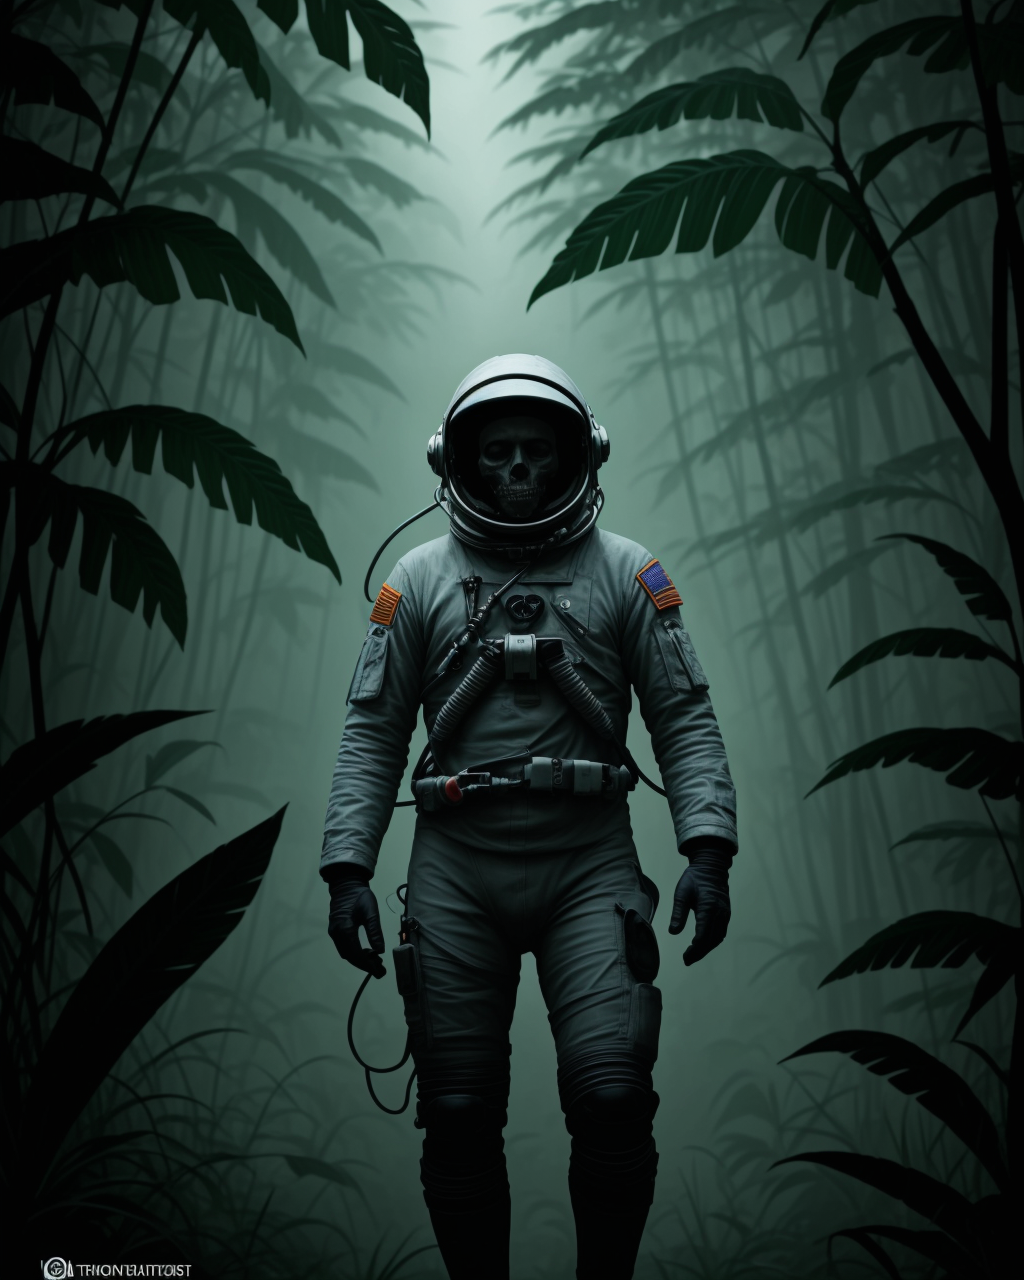

In [15]:
display(image_highresfix_output)

In [12]:
del pipeline
del image_highresfix_output
torch.cuda.empty_cache()